## Lab Seven: Sequential Networks
GROUP MEMBERS:
- **Alex Chen** 
- **Paige Maple** 
- **Sam Valentine**

### Sources
1. ChatGPT (For formatting text and plots)

### Preparation (3 pts total)

**Dataset Description and Prediction Task**

The dataset used in this lab is the [COVID-19 NLP Text Classification Dataset](https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification/data) from Kaggle, which contains thousands of user-generated text messages expressing reactions to the COVID-19 pandemic. Each entry includes a raw text document and an associated sentiment label, ranging from *Extremely Negative* to *Extremely Positive*. Because the dataset provides unprocessed natural language, it is ideal for demonstrating the full preprocessing pipeline, including tokenization and sequence length normalization. In this lab, we formulate a **many-to-one sentiment classification task**, where the goal is to predict the sentiment label of each text message from its sequence of tokens. This setup enables systematic comparison of sequential architectures such as CNNs, RNNs, and Transformers.

#### Part One (1 pts)

In [12]:
import numpy as np
import pandas as pd

# load the dataset and display basic info
df = pd.read_csv("../dataset/Corona_NLP_train.csv", encoding="ISO-8859-1")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# keep relevant columns
df = df[["OriginalTweet", "Sentiment"]].dropna()

label_map = {
    "Extremely Negative": 0,
    "Negative": 1,
    "Neutral": 2,
    "Positive": 3,
    "Extremely Positive": 4
}
df["Sentiment"] = df["Sentiment"].map(label_map)

# tokenizer
max_words = 20000
max_len = 50

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df["OriginalTweet"])

# convert to sequences
sequences = tokenizer.texts_to_sequences(df["OriginalTweet"])

# pad to fixed length
padded = pad_sequences(sequences, maxlen=max_len, padding="post")

# store sequences inside df
df["OriginalTweet"] = list(padded)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  41157 non-null  object
 1   Sentiment      41157 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 643.2+ KB


,OriginalTweet,Sentiment
0,"[1, 7251, 1, 13667, 8, 5, 6, 1, 7, 8, 5, 6, 1,...",2
1,"[536, 937, 3, 41, 2683, 280, 3, 2861, 892, 130...",3
2,"[12, 860, 1751, 3, 331, 333, 1402, 1934, 54, 2...",3
3,"[24, 89, 16, 42, 2, 109, 91, 180, 16, 232, 4, ...",3
4,"[92, 779, 3, 83, 22, 25, 60, 2, 39, 145, 4, 4,...",0


**Data Preparation and Preprocessing**

For this lab, we begin by preparing the COVID-19 NLP text dataset for a many-to-one sentiment classification task. We retain only the two relevant variables—**OriginalTweet** (raw text) and **Sentiment** (categorical label)—and remove any missing entries. The sentiment categories are then mapped to integer class labels from 0 to 4 to ensure compatibility with supervised learning models.

To prepare the input text for sequential neural architectures, we apply a **Keras Tokenizer** to convert each tweet into a sequence of integer token IDs. The tokenizer is fitted on the entire training corpus to build a vocabulary, after which every document is transformed into a sequence and padded to a fixed length. This step ensures that all sequences share a consistent dimensionality that can be processed by models such as CNNs, RNNs, and Transformers. The final preprocessed dataset consists of (1) integer-encoded sequences of equal length representing the text input and (2) integer class labels representing sentiment categories.

#### Part Two (1 pts)

**Evaluation Metrics**

For this sentiment classification task, accuracy alone is not an ideal metric because the dataset is not perfectly balanced across the five sentiment categories. Some sentiment classes, such as *Neutral* or *Negative*, appear more frequently than others, meaning that a model could achieve deceptively high accuracy by disproportionately predicting the majority classes. To obtain a more reliable and meaningful assessment of model performance, we use **macro-averaged F1-score** as the primary evaluation metric. Macro F1 treats each sentiment class equally by computing the F1-score for each class independently and then averaging them, making it sensitive to performance on minority classes. This is especially important in real-world sentiment analysis applications, where correctly identifying rare but strong emotions (e.g., *Extremely Negative*) can be as important as identifying common ones. In addition to macro F1, we will also report accuracy as a secondary metric for interpretability, but all model selection and comparisons will be guided by macro F1.

#### Part Three (1 pts)

In [16]:
from sklearn.model_selection import train_test_split

# features and labels
X = np.array(df["OriginalTweet"].tolist())
y = df["Sentiment"].values

# first split: 80% train, 20% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# second split: temp → 10% val, 10% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))

Train size: 32925
Validation size: 4116
Test size: 4116


**Train/Test Splitting Strategy**

To create a realistic evaluation environment for our sequence classification task, we divided the dataset using an **80/10/10 manual split**. This ensures that the model is trained on a sufficiently large subset while preserving dedicated validation and test sets for hyperparameter tuning and unbiased final evaluation.

We first separated 80% of the data for training and kept the remaining 20% for later splitting. The remaining portion was then divided evenly into **validation (10%)** and **test (10%)** sets. Stratified sampling was used in both steps to maintain the original sentiment class distribution across all three subsets. This approach mirrors real-world deployment: the validation set is used for model selection and tuning, while the test set represents unseen data for final performance assessment.

This split is appropriate because:

- It preserves class balance across all subsets.
- It prevents information leakage between training and evaluation data.
- It ensures that hyperparameter decisions are not influenced by the test set.
- Both validation and test sets have equal size, enabling fair comparison of evaluated metrics.

### Modeling (6 pts total)

#### Part One (3 pts)

In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

num_classes = 5 
vocab_size = min(max_words, len(tokenizer.word_index) + 1)
input_length = max_len

# ====== Model builders ======
def build_cnn_model(embedding_dim=128, num_filters=128, kernel_size=5, dropout_rate=0.5):
    inputs = layers.Input(shape=(input_length,))
    x = layers.Embedding(vocab_size, embedding_dim, input_length=input_length)(inputs)
    x = layers.Conv1D(num_filters, kernel_size, activation="relu")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs, outputs)
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        metrics=["accuracy"]
    )
    return model

def transformer_block(x, head_size=64, num_heads=2, ff_dim=128, dropout=0.1):
    attn_output = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads)(x, x)
    attn_output = layers.Dropout(dropout)(attn_output)
    out1 = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)

    ffn = layers.Dense(ff_dim, activation="relu")(out1)
    ffn = layers.Dense(x.shape[-1])(ffn)
    ffn = layers.Dropout(dropout)(ffn)
    out2 = layers.LayerNormalization(epsilon=1e-6)(out1 + ffn)
    return out2


def build_transformer_model(embedding_dim=128, head_size=64, num_heads=2, ff_dim=128, dropout=0.1):
    inputs = layers.Input(shape=(input_length,))
    x = layers.Embedding(vocab_size, embedding_dim)(inputs)
    x = transformer_block(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs, outputs)
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        metrics=["accuracy"]
    )
    return model


# ====== Build 4 models (2 CNN variants, 2 Transformer variants) ======
cnn_model_1 = build_cnn_model(embedding_dim=128, num_filters=128)   # baseline CNN
cnn_model_2 = build_cnn_model(embedding_dim=256, num_filters=64)    # changed embedding_dim & filters
transformer_model_1 = build_transformer_model(embedding_dim=128, num_heads=2)  # baseline Transformer
transformer_model_2 = build_transformer_model(embedding_dim=128, num_heads=4)  # more heads

# ====== Train models ======
batch_size = 64
epochs = 10

history_cnn_1 = cnn_model_1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=epochs
)

history_cnn_2 = cnn_model_2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=epochs
)

history_trans_1 = transformer_model_1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=epochs
)

history_trans_2 = transformer_model_2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=epochs
)

Epoch 1/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.4668 - loss: 1.2374 - val_accuracy: 0.6616 - val_loss: 0.8976
Epoch 2/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.6852 - loss: 0.8024 - val_accuracy: 0.6866 - val_loss: 0.8127
Epoch 3/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.7646 - loss: 0.6197 - val_accuracy: 0.7111 - val_loss: 0.7699
Epoch 4/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.8201 - loss: 0.4874 - val_accuracy: 0.7048 - val_loss: 0.8105
Epoch 5/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 38s 73ms/step - accuracy: 0.8632 - loss: 0.3735 - val_accuracy: 0.6927 - val_loss: 0.9008
Epoch 6/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 44s 86ms/step - accuracy: 0.8927 - loss: 0.3003 - val_accuracy: 0.6966 - val_loss: 1.0025
Epoch 7/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.9140 - loss: 0.2385 - val_accuracy: 0.6963 - val_loss: 1.1147
Epoch 8/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9291 - loss: 0.1976 - v

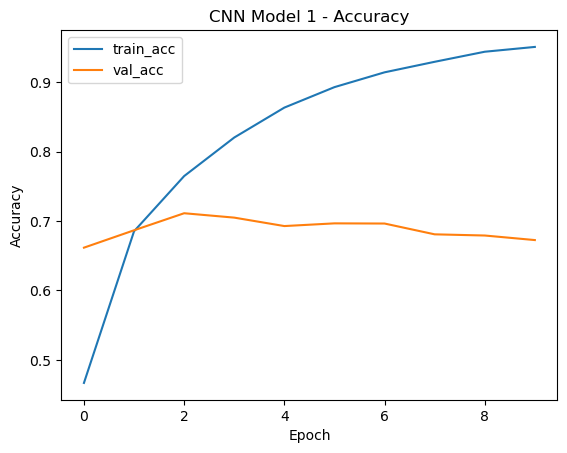

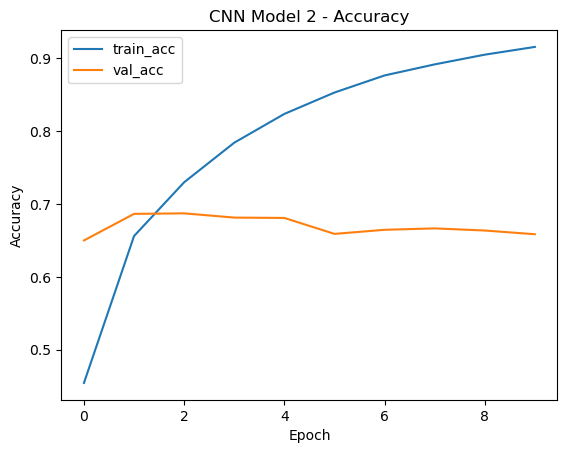

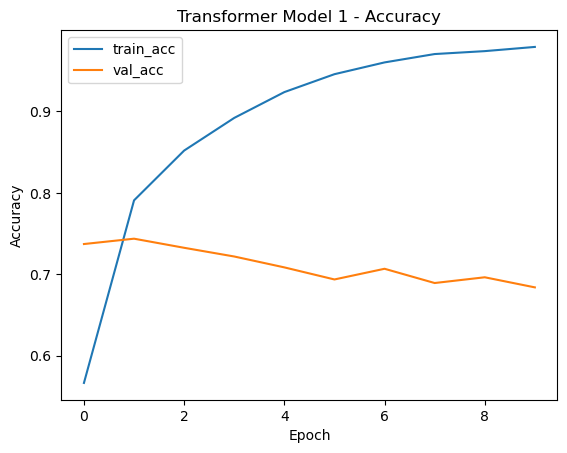

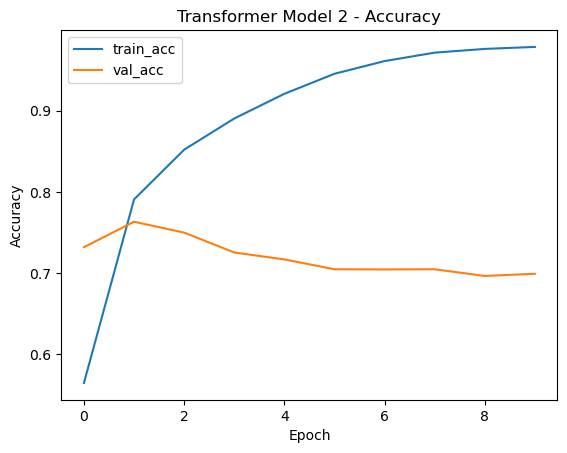

In [20]:
# ====== Simple plotting helper ======
def plot_history(history, title_prefix):
    # Accuracy
    plt.figure()
    plt.plot(history.history["accuracy"], label="train_acc")
    plt.plot(history.history["val_accuracy"], label="val_acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} - Accuracy")
    plt.legend()
    plt.show()

# Plot training curves
plot_history(history_cnn_1, "CNN Model 1")
plot_history(history_cnn_2, "CNN Model 2")
plot_history(history_trans_1, "Transformer Model 1")
plot_history(history_trans_2, "Transformer Model 2")

**Sequential Network Architectures**

To evaluate different sequential deep learning approaches for text classification, we implemented and trained four models: two Convolutional Neural Network (CNN) architectures and two Transformer-based architectures. Each pair includes a baseline model and a variant with modified hyperparameters to investigate their impact on generalization performance.
1. **CNN Model 1 (Baseline)**  
   The baseline CNN model uses an embedding dimension of 128 and 128 convolutional filters with a kernel size of 5. The architecture consists of an embedding layer, a 1D convolutional layer, global max pooling, dropout for regularization, and dense layers for classification. This model provides a strong classical baseline for sequence classification tasks.

2. **CNN Model 2 (Modified Hyperparameters)**  
   The second CNN model increases the embedding dimension to 256 while reducing the number of convolutional filters to 64. This variation explores how richer embeddings and fewer filters affect performance and learning stability. Adjusting these parameters allows comparison of model capacity versus convolutional complexity.

3. **Transformer Model 1 (Baseline)**  
   The baseline Transformer model includes an embedding layer followed by a single Transformer block with 2 attention heads and a feed-forward dimension of 128. It then applies global average pooling and dense layers for classification. This model tests how self-attention performs relative to convolution-based methods on this sentiment classification task.

4. **Transformer Model 2 (Modified Hyperparameters)**  
   The second Transformer model increases the number of attention heads from 2 to 4, allowing it to attend to more representational subspaces in parallel. This modification evaluates whether increased attention capacity improves performance on short-text sentiment classification.

All four models were trained using the same train/validation splits, batch size, and training epochs to ensure fair comparison. Training and validation accuracy were recorded and visualized to verify model convergence and relative performance.

#### Part Two (1 pts)

#### Part Three (2 pts)

### Exceptional Work (1 pts)
Use the pre-trained ConceptNet Numberbatch embedding and compare to the embedding you used above (it is fine to use either a CNN or a transformer for this section). Which method is better for your specific application? 